In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
X=np.load("X.npy")
Y=np.load("Y.npy")

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [5]:
input_size = 100
hidden_size = 200
num_classes = 500
num_epochs = 5
batch_size = 100
learning_rate = 0.0001

In [50]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=.4)
        self.batch_norm1 = nn.BatchNorm1d(input_size)
    
    def forward(self, x):
        out = self.batch_norm1(x)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        return out

In [51]:
model = Net(input_size,hidden_size,num_classes)
model.cuda()
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [52]:
X_train.shape[0]//10

293

In [53]:
Y_train.shape

(2936,)

In [54]:
epochs = 1000

In [55]:
X_train[:-6].shape

(2930, 100)

In [65]:
# test
losses=[]
dev_set_loss=[]
for epoch in range(epochs):
    
    epoch +=1
    for x,y in zip(np.split(X_train[:-6],X_train.shape[0]//10,axis=0),np.split(Y_train[:-6],Y_train.shape[0]//10,axis=0)):
        
        x=torch.from_numpy(x)
        y=torch.from_numpy(y)

        inputs = Variable(x.type(torch.cuda.FloatTensor))
        labels = Variable(y.type(torch.cuda.LongTensor))

        #clear grads
        optimizer.zero_grad()
        #forward to get predicted values
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

#         # let's check the state of dev set
        
#         inputs_dev = Variable(torch.from_numpy(X_dev).type(torch.cuda.FloatTensor))
#         labels_dev = Variable(torch.from_numpy(Y_dev).type(torch.cuda.LongTensor))
        
#         outputs_dev=model.forward(inputs_dev)
        
#         dev_set_loss.append(criterion(outputs_dev,labels_dev))
        try:
            if (float(loss)<min(losses)):
                torch.save(model.state_dict(),"DNN-MB+Droput+BatchNorm.pytorch")
        except ValueError as err:
            print(err)
        losses.append(float(loss))
        
        loss.backward()# back props
        optimizer.step()# update the parameters
    if(epoch%10 == 0):
        print("{} : {}".format(epoch,float(loss)))

min() arg is an empty sequence
10 : 1.717545747756958
20 : 1.701324224472046
30 : 1.5581729412078857
40 : 1.5605641603469849
50 : 1.7058807611465454
60 : 1.506032943725586
70 : 1.6366984844207764
80 : 1.69805908203125
90 : 1.6895725727081299
100 : 1.7194156646728516
110 : 1.5335307121276855
120 : 1.9426841735839844
130 : 1.6686550378799438
140 : 1.8624000549316406
150 : 1.427345633506775
160 : 1.7895091772079468
170 : 1.955057144165039
180 : 1.8184086084365845
190 : 1.5279074907302856
200 : 1.9402443170547485
210 : 1.5248801708221436
220 : 1.7741355895996094
230 : 1.5959856510162354
240 : 1.7139194011688232
250 : 1.6411174535751343
260 : 2.169755220413208
270 : 1.5349844694137573
280 : 1.6184618473052979
290 : 1.7093414068222046
300 : 1.970423936843872
310 : 1.7645256519317627
320 : 1.467538595199585
330 : 2.0535736083984375
340 : 1.0993353128433228
350 : 1.6224114894866943
360 : 1.820237398147583
370 : 1.4711573123931885
380 : 1.6203842163085938
390 : 2.004199504852295
400 : 1.9011512

KeyboardInterrupt: 

In [66]:
min(losses)

0.04875383526086807

## Evaluate the performance on the training data

In [67]:
# X_train and Y_train
model_pred=model(Variable(torch.from_numpy(X_train).type(torch.cuda.FloatTensor)))

train_correct=0
Y_train_pred=[]
total_train_compounds=len(Y_train)
for i,train_compound in enumerate(model_pred):
    
    
    max_,max_index=torch.max(train_compound,0)
    Y_train_pred.append(int(max_index))
    if (int(max_index)==Y_train[i]):
        train_correct+=1

print("The train accuracy is {}".format((train_correct/total_train_compounds)*100))

The train accuracy is 74.35286103542235


## Evaluate the model on the testing data

In [68]:
# X_test and Y_test
model_pred_test=model(Variable(torch.from_numpy(X_test).type(torch.cuda.FloatTensor)))

# The test accuracy
test_correct=0
Y_test_pred=[]
total_test_compounds=len(Y_test)
for i,test_compound in enumerate(model_pred_test):
    
    
    max_,max_index=torch.max(test_compound,0)
    Y_test_pred.append(int(max_index))
    if (int(max_index)==Y_test[i]):
        test_correct+=1

print("The test accuracy is {}".format((test_correct/total_test_compounds)*100))

The test accuracy is 70.9480122324159


In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
## Saved , uncomment the below line if you want to save it
# np.save("Y_test",Y_test)
# np.save("Y_test_pred.npy",np.array(Y_test_pred))

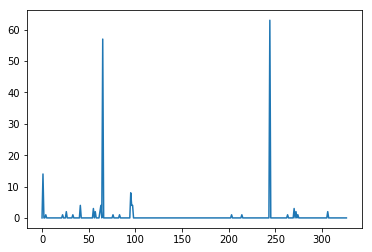

In [71]:
plt.plot(Y_test_pred)

In [72]:
## For the entire dataset

In [73]:
#X and Y
model_pred=model(Variable(torch.from_numpy(X).type(torch.cuda.FloatTensor)))
correct=0
Y_pred=[]
total_compounds=len(Y)
for i,compound in enumerate(model_pred):
    
    
    max_,max_index=torch.max(compound,0)
    Y_pred.append(int(max_index))
    if (int(max_index)==Y[i]):
        correct+=1

print("The total accuracy is {}".format((correct/total_compounds)*100))

The total accuracy is 73.67453263867606


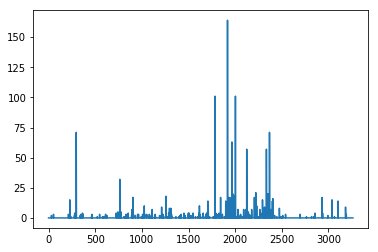

In [74]:
plt.plot(Y_pred)

In [24]:
torch.save(model.state_dict(),"mb_plus_droput.pytorch")

In [80]:
model.load_state_dict(torch.load("test.pytorch"))